In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
EXCEL_PATH = '/content/ecommerce_database_for_modeling2.xlsx'

In [11]:
df_dates = pd.read_excel(EXCEL_PATH, sheet_name="Dates", engine="openpyxl")

In [12]:
if 'registration_date' not in df_dates.columns:
    raise ValueError("الملف لا يحتوي على عمود 'registration_date' في شيت 'Dates'.")


In [13]:
df_dates['registration_date'] = pd.to_datetime(df_dates['registration_date'], errors='coerce')

In [14]:
df_dates = df_dates.dropna(subset=['registration_date']).copy()


In [16]:
df_monthly = df_dates.groupby(df_dates['registration_date'].dt.to_period('M')).size()

In [17]:
df_monthly.index = df_monthly.index.to_timestamp()
df_monthly = df_monthly.rename("registrations")

In [18]:
print("Monthly registrations (sample):")
print(df_monthly.head())


Monthly registrations (sample):
registration_date
2020-01-01    174
2020-02-01    155
2020-03-01    181
2020-04-01    155
2020-05-01    164
Freq: MS, Name: registrations, dtype: int64


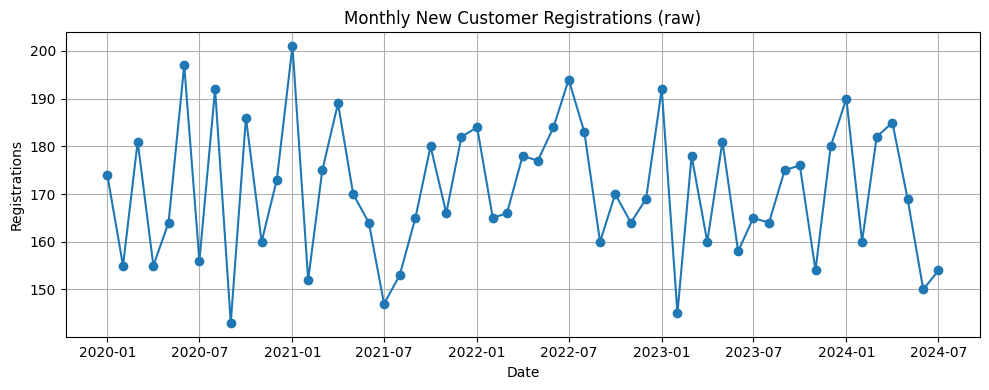

In [19]:
plt.figure(figsize=(10,4))
plt.plot(df_monthly, marker='o')
plt.title("Monthly New Customer Registrations (raw)")
plt.xlabel("Date")
plt.ylabel("Registrations")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
n_test = 12
train = df_monthly[:-n_test]
test  = df_monthly[-n_test:]


In [21]:
print(f"Train length: {len(train)} months, Test length: {len(test)} months")


Train length: 43 months, Test length: 12 months


In [22]:
order = (1,1,1)
seasonal_order = (1,1,1,12)

model = SARIMAX(train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                      registrations   No. Observations:                   43
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -64.216
Date:                            Sun, 23 Nov 2025   AIC                            138.432
Time:                                    19:12:22   BIC                            142.295
Sample:                                01-01-2020   HQIC                           138.630
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6297      0.284     -2.215      0.027      -1.187      -0.072
ma.L1         -0.4837      0.395   

In [23]:
pred_test = results.get_forecast(steps=len(test))
pred_test_mean = pred_test.predicted_mean
pred_test_ci = pred_test.conf_int()


In [26]:
future_steps = 12
pred_future = results.get_forecast(steps=len(test) + future_steps)
future_mean = pred_future.predicted_mean[-future_steps:]
future_ci = pred_future.conf_int().iloc[-future_steps:]


In [27]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1, y_true))) * 100

mae = mean_absolute_error(test, pred_test_mean)
rmse = np.sqrt(mean_squared_error(test, pred_test_mean))
mape_val = mape(test.values, pred_test_mean.values)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape_val:.2f}%")


MAE: 11.752, RMSE: 14.505, MAPE: 7.16%


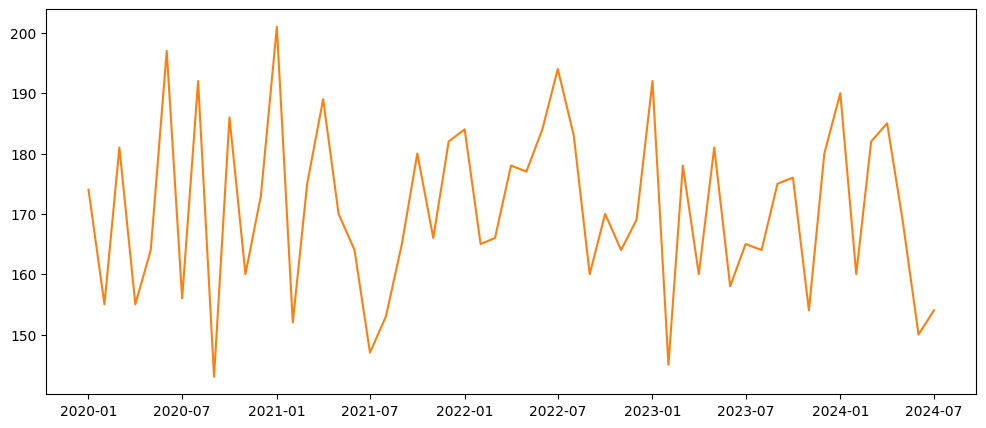

In [28]:
plt.figure(figsize=(12,5))
plt.plot(df_monthly, label='Observed', color='tab:orange')

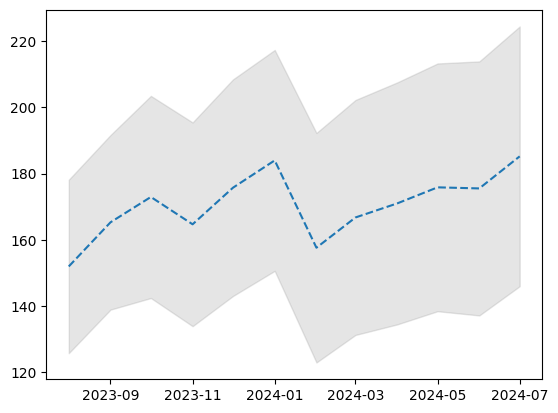

In [29]:
plt.plot(pred_test_mean.index, pred_test_mean, label='Forecast (test period)', linestyle='--')
plt.fill_between(pred_test_ci.index,
                 pred_test_ci.iloc[:,0],
                 pred_test_ci.iloc[:,1],
                 color='gray', alpha=0.2)

In [30]:
forecast_index = pd.date_range(start=future_mean.index[0], periods=len(future_mean), freq='MS')
future_df = pd.DataFrame({
    "forecast_mean": future_mean.values,
    "ci_lower": future_ci.iloc[:,0].values,
    "ci_upper": future_ci.iloc[:,1].values
}, index=future_mean.index)

In [31]:
output_df = pd.concat([
    df_monthly.rename("observed"),
    pred_test_mean.rename("forecast_test"),
    pred_test_ci.rename(columns={pred_test_ci.columns[0]:"ci_lower_test", pred_test_ci.columns[1]:"ci_upper_test"})
], axis=1)

In [32]:
with pd.ExcelWriter("monthly_registrations_forecast.xlsx") as writer:
    output_df.to_excel(writer, sheet_name="observed_and_test_forecast")
    future_df.to_excel(writer, sheet_name="future_12_months")

print("Saved forecast results to 'monthly_registrations_forecast.xlsx'")


Saved forecast results to 'monthly_registrations_forecast.xlsx'
